# Leopard-EM Demo - 2025 FrostByte meeting

Leopard-EM (**L**ocation & ori**E**ntati**O**n of **PAR**ticles found using two-**D**imensional t**E**mplate **M**atching) is a Python package providing an extensible framework for Two-Dimensional Template Matching (2DTM). This demonstration notebook covers the basic usage of Leopard-EM for locating macromolecular structures from *in situ* cryo-EM images.

*Note:* 2DTM & the Leopard-EM package extends beyond just identifying particles; leveraging 2DTM's sensitivity can identify 

## Demo Overview

1. [Installation](#installation)
2. [Data Prerequisites](#data-prerequisites)
3. [Configuring the `match_template` program](#configuring-the-match_template-program)
4. [Running `match_template`](#running-match_template)
5. [Analyzing Results](#analyzing-results)
6. [Helpful Visualizations](#helpful-visualizations)

## Installation

Leopard-EM is published [on PyPI](https://pypi.org/project/leopard-em/) and can be installed on Linux system using:
```bash
pip install leopard-em
```

In [1]:
!pip install leopard-em

### Additional demo package

We use the [zenodo_get](https://github.com/dvolgyes/zenodo_get) tool for downloading the example data hosted on Zenodo which is installed by the following cell

In [2]:
!pip install zenodo_get
!pip install matplotlib

## Data Prerequisites

The `match_template` program needs a **simulated map** (from a PDB model) to generate structure projections to cross-correlate with a **high-resolution cryo-EM micrograph**. Along with the reference template map, **estimated CTF defocus parameters** are needed to construct projective imaging filters.

For this demonstration, we have already performed the pre-processing steps with the following programs:

- [60S_map_px0.936_bscale0.5.mrc](60S_map_px0.936_bscale0.5.mrc) was simulated using PDB model 6Q8Y and the [ttsim3D package](https://github.com/teamtomo/ttsim3d) package.
- [xenon_217_000_0.0_DWS.mrc](xenon_217_000_0.0_DWS.mrc) was generated using [MotionCorr3](https://github.com/czimaginginstitute/MotionCor3) by processing data collected at CZII by Laina Hall.
- CTF parameters found using [CTFFIND5](https://elifesciences.org/reviewed-preprints/97227).

### Downloading input data

In [3]:
!zenodo_get https://doi.org/10.5281/zenodo.15426374 \
--glob "60S_map_px0.936_bscale0.5.mrc" \
--glob "xenon_217_000_0.0_DWS.mrc" \
--glob "xenon_217_000_0.0_DWS_config.yaml"

Title: 2DTM inputs and program results from the Leopard-EM Python package
Keywords: 
Publication date: 2025-05-15
DOI: 10.5281/zenodo.15426374
Total size: 604.0 MB

File: 60S_map_px0.936_bscale0.5.mrc (536.9 MB)
Link: https://zenodo.org/api/records/15426374/files/60S_map_px0.936_bscale0.5.mrc/content
100% [..................................................] 536871936 / 536871936
Checksum is correct for 60S_map_px0.936_bscale0.5.mrc. (4419d7ac93f5492b5f27a8a410b3d1fd)

File: xenon_217_000_0.0_DWS.mrc (67.1 MB)
Link: https://zenodo.org/api/records/15426374/files/xenon_217_000_0.0_DWS.mrc/content
100% [....................................................] 67109888 / 67109888
Checksum is correct for xenon_217_000_0.0_DWS.mrc. (002a4a6be7be460ffe03936735dfd491)

File: xenon_217_000_0.0_DWS_config.yaml (1.5 kB)
Link: https://zenodo.org/api/records/15426374/files/xenon_217_000_0.0_DWS_config.yaml/content
100% [............................................................] 1515 / 1515
Checksum 

## Configuring the `match_template` program

Inputs for Leopard-EM programs are handled by Pydantic models and defined in a hierarchical manner. For the `match_template` program, we have the associated `MatchTemplateManager` model which holds a reference to the input reference template, micrograph, 2DTM search configurations, and result output paths. Below, we go through constructing each of these Pydantic models.

In [4]:
from leopard_em.pydantic_models.config import (
    BandpassFilterConfig,
    ComputationalConfig,
    DefocusSearchConfig,
    OrientationSearchConfig,
    PreprocessingFilters,
    WhiteningFilterConfig,
)
from leopard_em.pydantic_models.data_structures import OpticsGroup
from leopard_em.pydantic_models.results import MatchTemplateResult
from leopard_em.pydantic_models.managers import MatchTemplateManager


### The `OpticsGroup` model and defocus parameters

The `OpticsGroup` model is a container for microscope imaging parameters necessary for calculating filters (e.g. contrast transfer functions).
We roughly follow [RELION's](https://relion.readthedocs.io/en/latest/) optics group naming convention.

The most important data-dependent fields are `defocus_u`, `defocus_v`, and `astigmatism_angle`. Defocus along the major/minor axes are defined in terms of Angstroms, and the astigmatism angle is in units of degrees

In [5]:
demo_optics_group = OpticsGroup(
    label="demo_optics_group",
    defocus_u=5691.740723,
    defocus_v=5184.807617,
    astigmatism_angle=68.171652,
    pixel_size=0.936,
    voltage=300.0,
    spherical_aberration=2.7,
    amplitude_contrast_ratio=0.07,
    phase_shift=0.0,
    ctf_B_factor=60.0,
)

### The `OrientationSearchConfig` model for sampling orientations

A 2DTM search necessitates a uniform sampling of orientation space in relatively fine increments since 2DTM is extremely sensitive to particle orientation. The `OrientationSearchConfig` model hold parameters related to orientation space, including angular spacing and particle symmetry.

In [6]:
demo_orientation_search = OrientationSearchConfig(
    psi_step=1.5,  # in plane rotations, degrees
    theta_step=2.5,  # out of plane rotations, degrees
    symmetry="C1",
)

The property `OrientationSearchConfig.euler_angles` returns a Tensor of Euler angles $(\phi, \theta, \psi)$ in ZYZ format which will be searcher over based on the given search parameters.

In [7]:
print(demo_orientation_search.euler_angles[:10])
demo_orientation_search.euler_angles.shape

tensor([[  0.0000,   0.0000,   0.0000],
        [  0.0000,   2.5000,   0.0000],
        [ 60.0000,   2.5000,   0.0000],
        [120.0000,   2.5000,   0.0000],
        [180.0000,   2.5000,   0.0000],
        [240.0000,   2.5000,   0.0000],
        [300.0000,   2.5000,   0.0000],
        [  0.0000,   5.0000,   0.0000],
        [ 27.6923,   5.0000,   0.0000],
        [ 55.3846,   5.0000,   0.0000]], dtype=torch.float64)


torch.Size([1584480, 3])

### The `DefocusSearchConfig` model

2DTM is also sensitive to defocus, and the `DefocusSearchConfig` model handles which defocus planes are sampled during a search. Defocus offset planes are relative to the `defocus_u` and `defocus_v` parameters defined in the optics group, and the config effectively acts as a range object.

In [8]:
demo_defocus_search= DefocusSearchConfig(
    defocus_step=200.0,  # in Angstroms
    defocus_min=-1200.0,  # in Angstroms
    defocus_max=1200.0,  # in Angstroms
)

Like before, the property `DefocusSearchConfig.defocus_values` returns a Tensor of relative defocus values.

In [9]:
demo_defocus_search.defocus_values

tensor([-1200., -1000.,  -800.,  -600.,  -400.,  -200.,     0.,   200.,   400.,
          600.,   800.,  1000.,  1200.])

### Image and projection filtering with `PreprocessingFilters`

Pre-processing filters are applied to the image and template in 2DTM, namely spectral whitening, in the Fourier domain. Leopard-EM includes other types of Fourier filters, like band-pass filters, which are configured under the `PreprocessingFilters` model.

We will focus on the whitening and band-pass filters.

#### The `WhiteningFilterConfig` model

For most cases, the default config values for spectral whitening will suffice which calculate a whitening filter based on the image power spectral density out to the Nyquist frequency. The whitening filter is enabled by default.

In [10]:
demo_whitening_filter = WhiteningFilterConfig(enabled=True, max_freq=0.5)

#### The `BandpassFilterConfig` model

Band-pass filtering is disabled by default, but can be easily enabled. Note that spatial frequencies here are defined in terms of the Nyquist frequency.

In [11]:
demo_bandpass_filter = BandpassFilterConfig(
    enabled=True,
    low_freq_cutoff=None,
    high_freq_cutoff=0.312,  # low-pass to 3 Å @ 0.936 Å/px
    falloff=0.1,  # smooth transition
)

#### Combining into `PreprocessingFilters` instance

In [12]:
demo_preprocessing_filters = PreprocessingFilters(
    whitening_filter=demo_whitening_filter,
    bandpass_filter=demo_bandpass_filter,
)

### Targeting hardware with the `ComputationalConfig`

Leopard-EM supports multi-GPU systems, and specific GPUs can be targeted using the `ComputationalConfig` model. This is an easy way to speed up computation if you have the available GPU resources

*Note:* We will add support for multi-node systems in the near future. Currently, all GPUs must be on the same physical machine.

In [13]:
demo_computational_config = ComputationalConfig(gpu_ids=[0, 1])

### Result outputs with `MatchTemplateResult` model

We almost have a complete set of configurations for the `match_template` program, but we still need to specify where to save results after the program completes.
The `MatchTemplateResult` model handles this by specifying output file paths.

The model supports both absolute and relative paths, and the file are checked for writeability before running the GPU-intensive code. Below, we specify the paths should be saved to the `results` dir in the current working directory.

In [14]:
demo_match_template_result = MatchTemplateResult(
    allow_file_overwrite=True,
    mip_path="xenon_217_000_0_output_mip.mrc",
    scaled_mip_path="xenon_217_000_0_output_scaled_mip.mrc",
    correlation_average_path="xenon_217_000_0_output_correlation_average.mrc",
    correlation_variance_path="xenon_217_000_0_output_correlation_variance.mrc",
    orientation_psi_path="xenon_217_000_0_output_orientation_psi.mrc",
    orientation_theta_path="xenon_217_000_0_output_orientation_theta.mrc",
    orientation_phi_path="xenon_217_000_0_output_orientation_phi.mrc",
    relative_defocus_path="xenon_217_000_0_output_relative_defocus.mrc",
)

### Instantiating the `MatchTemplateManager` model

Finally, we have all the components which go into the main manager object. There are the additional attributes for the simulated template volume and micrograph paths with the remaining attributes being other Pydantic models.

In [15]:
demo_match_template_manager = MatchTemplateManager(
    micrograph_path="xenon_217_000_0.0_DWS.mrc",
    template_volume_path="60S_map_px0.936_bscale0.5.mrc",
    optics_group=demo_optics_group,
    defocus_search_config=demo_defocus_search,
    orientation_search_config=demo_orientation_search,
    preprocessing_filters=demo_preprocessing_filters,
    match_template_result=demo_match_template_result,
    computational_config=demo_computational_config,
)

### A brief note on serialization

The beauty of Pydantic models is that they easily support key, value serialization structures like JSON or YAML. The contents of the manager object can be converted to a dictionary or written to a YAML file.

In [16]:
demo_match_template_manager.model_dump()

{'micrograph_path': 'xenon_217_000_0.0_DWS.mrc',
 'template_volume_path': '60S_map_px0.936_bscale0.5.mrc',
 'optics_group': {'label': 'demo_optics_group',
  'pixel_size': 0.936,
  'voltage': 300.0,
  'spherical_aberration': 2.7,
  'amplitude_contrast_ratio': 0.07,
  'phase_shift': 0.0,
  'defocus_u': 5691.740723,
  'defocus_v': 5184.807617,
  'astigmatism_angle': 68.171652,
  'ctf_B_factor': 60.0,
  'chromatic_aberration': 0.0,
  'mtf_reference': None,
  'mtf_values': None,
  'beam_tilt_x': None,
  'beam_tilt_y': None,
  'odd_zernike': None,
  'even_zernike': None,
  'zernike_moments': None},
 'defocus_search_config': {'enabled': True,
  'defocus_min': -1200.0,
  'defocus_max': 1200.0,
  'defocus_step': 200.0,
  'skip_enforce_zero': False},
 'orientation_search_config': {'psi_step': 1.5,
  'theta_step': 2.5,
  'phi_min': 0.0,
  'phi_max': 360.0,
  'theta_min': 0.0,
  'theta_max': 180.0,
  'psi_min': 0.0,
  'psi_max': 360.0,
  'base_grid_method': 'uniform',
  'symmetry': 'C1'},
 'prepro

In [17]:
# Export to a YAML file
demo_match_template_manager.to_yaml("demo_match_template_config.yaml")

Similarly, a configuration can be written entirely in a YAML file and loaded using a single line of Python. This is the recommended way for configuring the `match_template` program

Below, we load in the configuration from above into a new manager object and check that they're equal.

In [18]:
# Load from a YAML file
new_match_template_manager = MatchTemplateManager.from_yaml("demo_match_template_config.yaml")

assert new_match_template_manager == demo_match_template_manager

## Running `match_template`

Now that we've configured the `MatchTemplateManager` object, we can move onto running the program which is as easy as calling:
```python
demo_match_template_manager.run_match_template()
```

Actually, since this is so simple we can look a little deeper into *how* the manager object is running the underlying program.

### Generating core function keyword arguments

The `MatchTemplateManager` object provides a convenient interface to the core `leopard_em.backend.core_match_template` function by automatically generating the appropriate keyword arguments from its Pydantic models. This abstraction layer ensures type safety and validation while maintaining flexibility in configuration.

[Template Matching Layout](fig01-layout.pdf)

These keyword argument are generated before calling the backend of the Leopard-EM package. We inspect these data below

In [19]:
core_kwargs = demo_match_template_manager.make_backend_core_function_kwargs()

In [20]:
# Print with aligned formatting
max_key_len = max(len(k) for k in core_kwargs.keys())
for k in core_kwargs.keys():
    print(f"{k:<{max_key_len}}: {type(core_kwargs[k])}")

image_dft                : <class 'torch.Tensor'>
template_dft             : <class 'torch.Tensor'>
ctf_filters              : <class 'torch.Tensor'>
whitening_filter_template: <class 'torch.Tensor'>
euler_angles             : <class 'torch.Tensor'>
defocus_values           : <class 'torch.Tensor'>
pixel_values             : <class 'torch.Tensor'>
device                   : <class 'list'>


Some of these data we have already seen, like `euler_angles` and `defocus_values` from the configuration objects.

If we look at the signature of the `core_match_template` function, we see many of these keyword arguments line up.
```python
def core_match_template(
    image_dft: torch.Tensor,
    template_dft: torch.Tensor,  # already fftshifted
    ctf_filters: torch.Tensor,
    whitening_filter_template: torch.Tensor,
    defocus_values: torch.Tensor,
    pixel_values: torch.Tensor,
    euler_angles: torch.Tensor,
    device: torch.device | list[torch.device],
    orientation_batch_size: int = 1,
) -> dict[str, torch.Tensor]:
```

Note that there is an additional `orientation_batch_size` parameter which can help scale performance across different types of GPUs (namely available GPU memory). Now we will actually call the run function and see what happens...

In [21]:
demo_match_template_manager.run_match_template(orientation_batch_size=4)

Progress on device: 0:   0%|          | 131/198060 [00:14<5:59:42,  9.17it/s]
Process Process-2:
Traceback (most recent call last):
  File "/home/mgiammar/miniconda3/envs/FrostByte2025/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/mgiammar/miniconda3/envs/FrostByte2025/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mgiammar/miniconda3/envs/FrostByte2025/lib/python3.12/site-packages/leopard_em/backend/core_match_template.py", line 372, in _core_match_template_single_gpu
    rot_matrix = roma.euler_to_rotmat(
                 ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mgiammar/miniconda3/envs/FrostByte2025/lib/python3.12/site-packages/roma/euler.py", line 100, in euler_to_rotmat
    return roma.unitquat_to_rotmat(euler_to_unitquat(convention=convention, angles=angles, degrees=degrees, dtype=dtype, device=device))
                                   ^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

### (optional) Download the already processed data

Since the template matching process can take upwards of 10 hours, we can also download the already processed results from Zenodo using the cell below.

In [22]:
!zenodo_get https://doi.org/10.5281/zenodo.15426374 \
--glob "xenon_217_000_0.0_DWS_results.csv" \
--glob "xenon_217_000_0_output_correlation_average.mrc" \
--glob "xenon_217_000_0_output_correlation_variance.mrc" \
--glob "xenon_217_000_0_output_mip.mrc" \
--glob "xenon_217_000_0_output_scaled_mip.mrc" \
--glob "xenon_217_000_0_output_orientation_phi.mrc" \
--glob "xenon_217_000_0_output_orientation_theta.mrc" \
--glob "xenon_217_000_0_output_orientation_psi.mrc"

Title: 2DTM inputs and program results from the Leopard-EM Python package
Keywords: 
Publication date: 2025-05-15
DOI: 10.5281/zenodo.15426374
Total size: 360.1 MB

File: xenon_217_000_0_output_orientation_phi.mrc (51.4 MB)
Link: https://zenodo.org/api/records/15426374/files/xenon_217_000_0_output_orientation_phi.mrc/content
100% [....................................................] 51409924 / 51409924
Checksum is correct for xenon_217_000_0_output_orientation_phi.mrc. (7d571d4a435f00fc5fb06b180c3d5786)

File: xenon_217_000_0_output_correlation_average.mrc (51.4 MB)
Link: https://zenodo.org/api/records/15426374/files/xenon_217_000_0_output_correlation_average.mrc/content
100% [....................................................] 51409924 / 51409924
Checksum is correct for xenon_217_000_0_output_correlation_average.mrc. (ad1f06bd6c245f75df68a90c5f1729f1)

File: xenon_217_000_0.0_DWS_results.csv (181.2 kB)
Link: https://zenodo.org/api/records/15426374/files/xenon_217_000_0.0_DWS_result

## Analyzing results

Before ending with a few neat visualizations, we will go what results the match template program writes to disk after completion. The types of results can be grouped under two major categories:

1. Per-pixel results for correlation values, particle orientations, and relative defocus values saved as mrc files, and
2. Location & orientation information specific to particles which surpass the cutoff threshold saved as a csv file.

In [23]:
import mrcfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

### Results DataFrame

In [24]:
results_df = pd.read_csv("xenon_217_000_0.0_DWS_results.csv")

# Print out all column names
display(results_df.columns)

# Display the DataFrame for a few spesific columns
cols = [
    "mip",
    "scaled_mip",
    "pos_x",
    "pos_y",
    "phi",
    "theta",
    "psi",
    "relative_defocus",
    "mip_path",
    "scaled_mip_path",
]
results_df[cols]

Index(['Unnamed: 0', 'particle_index', 'mip', 'scaled_mip', 'correlation_mean',
       'correlation_variance', 'total_correlations', 'pos_x', 'pos_y',
       'pos_x_img', 'pos_y_img', 'pos_x_img_angstrom', 'pos_y_img_angstrom',
       'phi', 'theta', 'psi', 'relative_defocus', 'refined_relative_defocus',
       'defocus_u', 'defocus_v', 'astigmatism_angle', 'pixel_size',
       'refined_pixel_size', 'voltage', 'spherical_aberration',
       'amplitude_contrast_ratio', 'phase_shift', 'ctf_B_factor',
       'micrograph_path', 'template_path', 'mip_path', 'scaled_mip_path',
       'psi_path', 'theta_path', 'phi_path', 'defocus_path',
       'correlation_average_path', 'correlation_variance_path'],
      dtype='object')

,mip,scaled_mip,pos_x,pos_y,phi,theta,psi,relative_defocus,mip_path,scaled_mip_path
0,12.452538,12.323128,898,1056,120.83916,82.5,325.5,-600.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
1,12.434317,12.222692,1725,218,12.50000,90.0,217.5,800.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
2,12.844589,12.139876,1595,2316,352.50000,87.5,66.0,800.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
3,11.892641,12.064082,13,867,193.09091,50.0,108.0,-200.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
4,13.097201,12.002978,2600,2803,166.15384,85.0,63.0,-400.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
...,...,...,...,...,...,...,...,...,...,...
298,8.569118,7.900208,254,3132,176.84210,52.5,42.0,200.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
299,8.088312,7.900015,2930,3068,320.62500,62.5,207.0,-1200.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
300,8.405449,7.857557,1261,586,164.16000,120.0,274.5,600.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc
301,8.210009,7.848620,1944,333,93.50649,147.5,321.0,800.0,xenon_217_000_0_output_mip.mrc,xenon_217_000_0_output_scaled_mip.mrc


## Helpful Visualizations

### Plotting the z-score map

In [25]:
scaled_mip = mrcfile.read("xenon_217_000_0_output_scaled_mip.mrc")

In [26]:
# Define the region of interest to zoom in on
region_pos_x = 800
region_pos_y = 2300
region_width = 256

# Extract the region of interest from the mip
region_scaled_mip = scaled_mip[
    region_pos_y : region_pos_y + region_width,
    region_pos_x : region_pos_x + region_width,
]

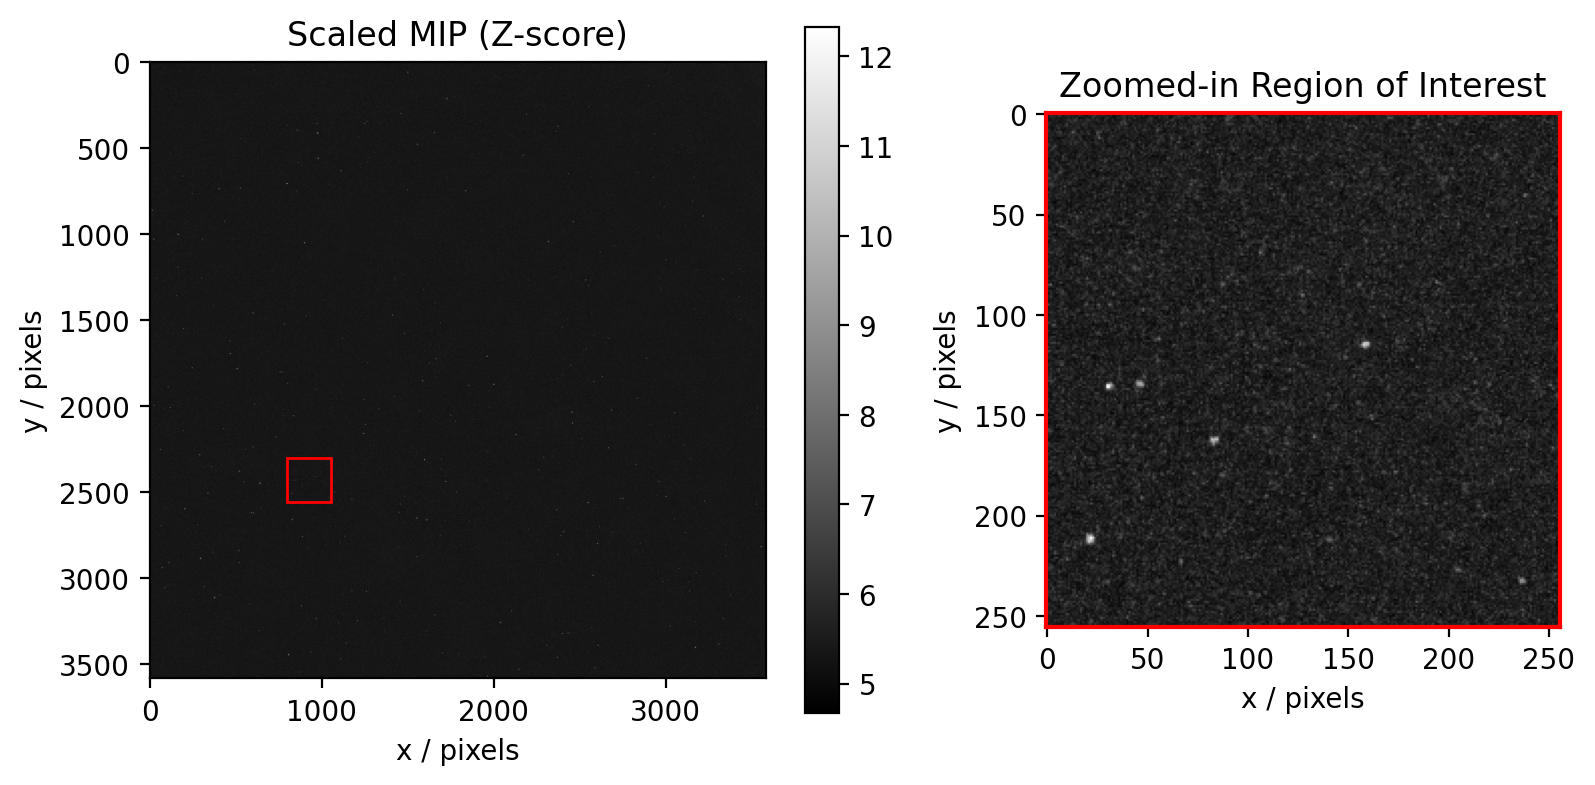

In [27]:
# Plot the full image and the zoomed-in region
fig, ax = plt.subplots(
    1, 2, figsize=(8, 4), gridspec_kw={"width_ratios": [0.6, 0.4]}
)

cmap = "grey"

# Image of the entire MIP
im = ax[0].imshow(scaled_mip, cmap=cmap)
cbar = plt.colorbar(im, ax=ax[0], orientation="vertical")
ax[0].set_title("Scaled MIP (Z-score)")
ax[0].set_xlabel("x / pixels")
ax[0].set_ylabel("y / pixels")

# box around the region of interest
rect = plt.Rectangle(
    (region_pos_x, region_pos_y),
    region_width,
    region_width,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax[0].add_patch(rect)

ax[1].imshow(region_scaled_mip, cmap=cmap)
ax[1].set_title("Zoomed-in Region of Interest")
ax[1].set_xlabel("x / pixels")
ax[1].set_ylabel("y / pixels")
# Make the spines of the axes on the zoomed-in region red
for spine in ax[1].spines.values():
    spine.set_edgecolor("red")
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

## Best orientations represented by color

Here, we take the three Euler angles $(\phi, \theta, \psi)$ defining the best orientation per-pixel and map them to an RGB image to plot the orientation information.
Note that this coloring scheme does not account for the periodic nature of orientation space, and the relative color difference should only be used for visualization purposes.

In [28]:
orientation_phi = mrcfile.read("xenon_217_000_0_output_orientation_phi.mrc")
orientation_theta = mrcfile.read("xenon_217_000_0_output_orientation_theta.mrc")
orientation_psi = mrcfile.read("xenon_217_000_0_output_orientation_psi.mrc")

In [29]:
phi_region = orientation_phi[
    region_pos_y : region_pos_y + region_width,
    region_pos_x : region_pos_x + region_width,
]
theta_region = orientation_theta[
    region_pos_y : region_pos_y + region_width,
    region_pos_x : region_pos_x + region_width,
]
psi_region = orientation_psi[
    region_pos_y : region_pos_y + region_width,
    region_pos_x : region_pos_x + region_width,
]

# Normalize the orientation data to the range [0, 1]
phi_region = phi_region / 360
theta_region = theta_region / 180
psi_region = psi_region / 360
orientation_rgb = np.stack((phi_region, theta_region, psi_region), axis=-1)

# Add alpha channel based on scaled_mip
alpha_channel = scaled_mip[
    region_pos_y : region_pos_y + region_width,
    region_pos_x : region_pos_x + region_width,
]
alpha_channel = (alpha_channel - np.min(alpha_channel)) / (
    np.max(alpha_channel) - np.min(alpha_channel)
)
orientation_rgba = np.zeros(
    (orientation_rgb.shape[0], orientation_rgb.shape[1], 4), dtype=np.float32
)
orientation_rgba[..., :3] = orientation_rgb
orientation_rgba[..., 3] = alpha_channel

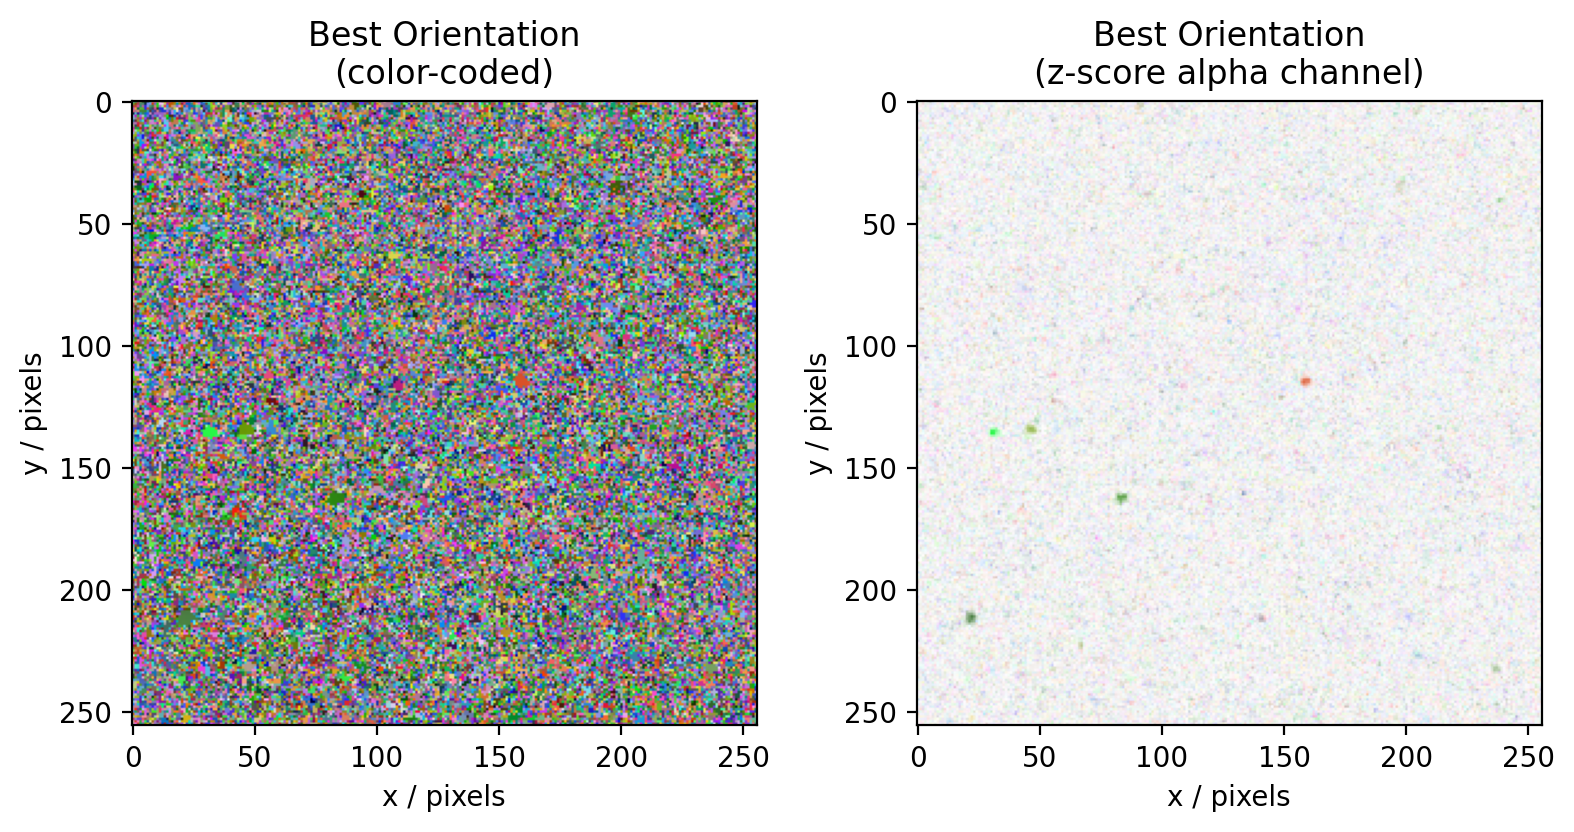

In [30]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

ax0.imshow(orientation_rgb)
ax0.set_title("Best Orientation\n(color-coded)")
ax0.set_xlabel("x / pixels")
ax0.set_ylabel("y / pixels")

ax1.imshow(orientation_rgba)
ax1.set_title("Best Orientation\n(z-score alpha channel)")
ax1.set_xlabel("x / pixels")
ax1.set_ylabel("y / pixels")

plt.tight_layout()
plt.show()